#  Algorithm training, testing, and validation

In the first 2 parts of our project we extracted solar radiation data for Boulogne-Billancourt (Greater Paris, France), cleaned the data and formated our data, then visualized our data in order to get some insights.
In this new section of our project, we are going to predict daily solar radiations in Boulogne - Billancour using the variables contained in our dataset.

## I- Import libraries and dataset

In [1]:
# import libraries
import numpy as np
import pandas as pd
#import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, RepeatedKFold, KFold
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
import xgboost as xgb
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning) 
#sns.set() # Revert to matplotlib defaults
plt.rcParams['figure.figsize'] = (16, 12)

In [2]:
# Load dataset
df = pd.read_csv("solarcast_df_clean281221.csv")

In [3]:
# Display column names
df.columns

Index(['Unnamed: 0', 'MonthPE', 'Date', 'Season', 'Daily_Temp', 'Daily_Precip',
       'Daily_Humidity', 'Daily_Pressure', 'Daily_WindDir', 'Daily_WindSpeed',
       'Daily_DNI', 'Daily_GHI', 'Daily_radiation'],
      dtype='object')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1087 entries, 0 to 1086
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       1087 non-null   object 
 1   MonthPE          1087 non-null   int64  
 2   Date             1087 non-null   object 
 3   Season           1087 non-null   object 
 4   Daily_Temp       1087 non-null   float64
 5   Daily_Precip     1087 non-null   float64
 6   Daily_Humidity   1087 non-null   float64
 7   Daily_Pressure   1087 non-null   float64
 8   Daily_WindDir    1087 non-null   float64
 9   Daily_WindSpeed  1087 non-null   float64
 10  Daily_DNI        1087 non-null   float64
 11  Daily_GHI        1087 non-null   float64
 12  Daily_radiation  1087 non-null   float64
dtypes: float64(9), int64(1), object(3)
memory usage: 110.5+ KB


In [5]:
# Feature Engineering of Time Series Column
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month
df['day'] = df['Date'].dt.day

In [6]:
# Display column names
df.columns

Index(['Unnamed: 0', 'MonthPE', 'Date', 'Season', 'Daily_Temp', 'Daily_Precip',
       'Daily_Humidity', 'Daily_Pressure', 'Daily_WindDir', 'Daily_WindSpeed',
       'Daily_DNI', 'Daily_GHI', 'Daily_radiation', 'year', 'month', 'day'],
      dtype='object')

In [7]:
# Select features to be used for modelling
df = df[['month', 'day','Daily_Temp', 'Daily_Precip', 'Daily_Humidity',
       'Daily_Pressure', 'Daily_WindDir', 'Daily_WindSpeed', 'Daily_DNI',
       'Daily_GHI', 'Daily_radiation']]
df.head()

,month,day,Daily_Temp,Daily_Precip,Daily_Humidity,Daily_Pressure,Daily_WindDir,Daily_WindSpeed,Daily_DNI,Daily_GHI,Daily_radiation
0,12,31,7.855556,13.611111,95.111111,1020.955556,329.777778,1.844444,0.000000,34.444444,34.444444
1,1,1,6.900000,9.833333,89.888889,1019.022222,307.888889,3.522222,0.000000,35.888889,35.888889
2,1,2,4.266667,6.800000,73.666667,1024.233333,12.222222,4.600000,10.444444,67.000000,66.222222
3,1,3,2.800000,7.600000,83.222222,1024.522222,22.666667,3.233333,22.111111,83.666667,81.777778
4,1,4,2.011111,8.522222,86.222222,1024.433333,15.222222,3.077778,33.777778,65.222222,58.222222


## II- Model training and testing

### a) Model training

In [8]:
# produces a 70%, 15%, 15% split for training, validation and test sets
train_data, validation_data, test_data = np.split(df.sample(frac = 1), [int(.7 * len(df)), int(.85 * len(df))])

In [9]:
# Convert dataframes to .csv and save locally
train_data.to_csv('solarcast_train.csv', header = True, index = False)
validation_data.to_csv('solarcast_validation.csv', header=True, index = False)
test_data.to_csv('solarcast_test.csv', header = True, index = False)

In [10]:
# Training data
train_df = pd.read_csv('solarcast_train.csv')
X_train = train_df.drop(['Daily_radiation'], axis = 1)
y_train = train_df['Daily_radiation']

# Test data
test_df = pd.read_csv('solarcast_test.csv')
X_test = test_df.drop(['Daily_radiation'], axis = 1)
y_test = test_df['Daily_radiation']

In [11]:
# Create a pipeline to scale our data then fit our different models
pipelines = {
    'LR': make_pipeline(StandardScaler(), LinearRegression()),
    'RFC': make_pipeline(StandardScaler(), RandomForestRegressor(random_state=1)),
    'XGB': make_pipeline(StandardScaler(), xgb.XGBRegressor(objective ='reg:squarederror', random_state=1)),
    'CART': make_pipeline(StandardScaler(), DecisionTreeRegressor(random_state=1)),
    'LGB': make_pipeline(StandardScaler(),lgb.LGBMRegressor(random_state=1))
}

In [12]:
# Check the content of our pipeline dictionary
pipelines.items()

dict_items([('LR', Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])), ('RFC', Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=1))])), ('XGB', Pipeline(steps=[('standardscaler', StandardScaler()),
                ('xgbregressor',
                 XGBRegressor(base_score=None, booster=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, enable_categorical=False,
                              gamma=None, gpu_id=None, importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_delta_step=None, max_depth=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=100,
                         

In [13]:
# The following code fits the model, and evoluate model performance
# through cross validation in order to see how models generalize
results = []
names = []
for name, model in pipelines.items():
    # Fit model on X_train, y_train
    model.fit(X_train.values, y_train)
    # Store model in fitted_models[name] for later use
    # Print '{name} has been fitted'
    print(name, 'has been fitted.')

    # Cross validation in order to see how the model generalizes across 10 foldS
    kfold = KFold(n_splits=10, random_state=1, shuffle=True)#
    cv_results = cross_val_score(model, X_train.values, y_train, cv=kfold, scoring='r2')
    results.append(cv_results)
    names.append(name)
    # Print average r2 and standard deviation of r2 based on 10 CV folds
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

LR has been fitted.
LR: 0.816533 (0.033377)
RFC has been fitted.
RFC: 0.955916 (0.011157)
XGB has been fitted.
XGB: 0.955263 (0.007053)
CART has been fitted.
CART: 0.913450 (0.023987)
LGB has been fitted.
LGB: 0.966441 (0.004782)


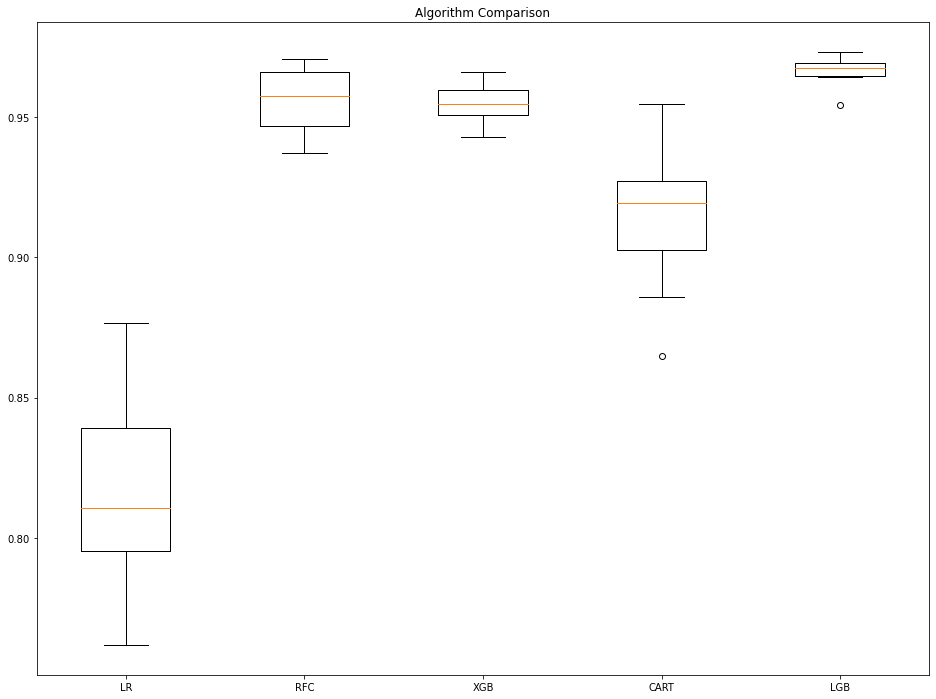

In [14]:
# Visualize performace of each model using boxplots
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison')
plt.show()

Among our 5 models, LightGBM is the one performing better in terms of average R2 score on the 10 folds. This model is also the one that generalizes better as shown by the CV r2 standard deviation in parenthesis.

### b) Evaluating model on test set

Now we wil evaluate the model performance of our 5 models using the test set. We will make predictions on the test and compare our predictions vs actual values.

***Linear Regression***

In [15]:
pipeline_lr = pipelines['LR'].fit(X_train.values, y_train)
# Make prediction on the test set
y_pred_lr = pipeline_lr.predict(X_test.values)

In [16]:
mse_lr = mean_squared_error(y_test, y_pred_lr, squared = False)
mae_lr = mean_absolute_error(y_test, y_pred_lr)

print('Linear Regression model performance - test set')
print('r2_score: ', r2_score(y_test, y_pred_lr))
print('Root Mean Squared Error: %.2f' % np.sqrt(mse_lr))
print('Root Mean Absolute Error: %.2f' % np.sqrt(mae_lr))

Linear Regression model performance - test set
r2_score:  0.8043174958238947
Root Mean Squared Error: 5.20
Root Mean Absolute Error: 4.76


Now let's visualize model prediction residuals ie true value - predicted value.

In [17]:
pipelines['LR']['linearregression']

LinearRegression()

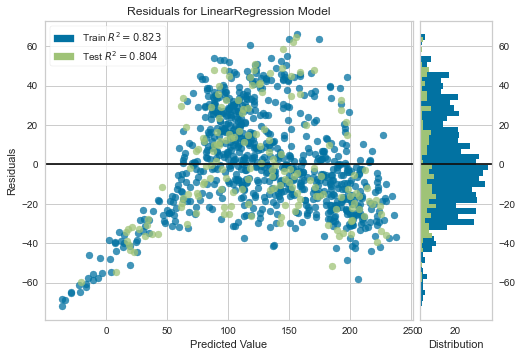

In [18]:
from yellowbrick.regressor import ResidualsPlot
visualizer = ResidualsPlot(pipeline_lr)

visualizer.fit(X_train.values, y_train)  
visualizer.score(X_test.values, y_test)  
visualizer.show();                

Looking at the graph above, we notice a long tail for which residuals are between -20 and - 70, and predicted values inferior to 50.
When performing data visualization in our previous notebook, we noticed that the relationships between Daily radiations and other features were not linear. This probably explains the poor performance we see here on some of the data points.

Now we will visualize predictions vs actual target values.

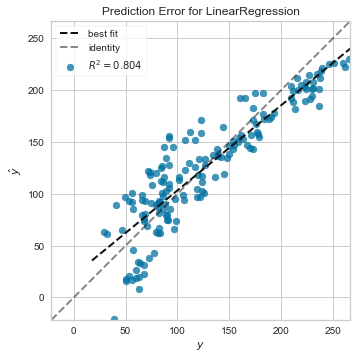

In [19]:
from yellowbrick.regressor import PredictionError

visualizer2 = PredictionError(pipeline_lr)
visualizer2.fit(X_train.values, y_train)  # Fit the training data to the visualizer
visualizer2.score(X_test.values, y_test)  # Evaluate the model on the test data
visualizer2.show();                 # Finalize and render the figure

The model regression line is quite far off the identify line ie the line where predictions = actual values.

***Random Forest***

In [20]:
pipeline_rfc = pipelines['RFC'].fit(X_train.values, y_train)
# Make prediction on the test set
y_pred_rfc = pipeline_rfc.predict(X_test.values)

In [21]:
mse_rfc = mean_squared_error(y_test, y_pred_rfc, squared = False)
mae_rfc = mean_absolute_error(y_test, y_pred_rfc)

print('RandomForest model performance - test set')
print('r2_score: ', r2_score(y_test, y_pred_rfc))
print('Root Mean Squared Error: %.2f' % np.sqrt(mse_rfc))
print('Root Mean Absolute Error: %.2f' % np.sqrt(mae_rfc))

RandomForest model performance - test set
r2_score:  0.9678653140340957
Root Mean Squared Error: 3.31
Root Mean Absolute Error: 2.84


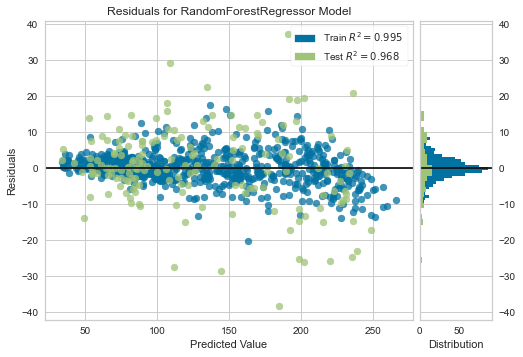

In [22]:
visualizer3 = ResidualsPlot(pipeline_rfc)

visualizer3.fit(X_train.values, y_train)  
visualizer3.score(X_test.values, y_test)  
visualizer3.show();                 

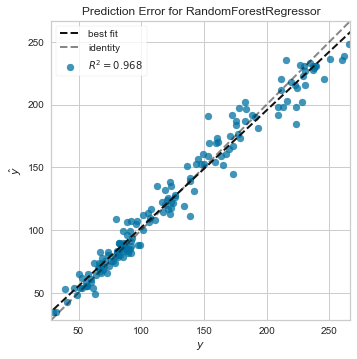

In [23]:
visualizer4 = PredictionError(pipeline_rfc)
visualizer4.fit(X_train.values, y_train)  
visualizer4.score(X_test.values, y_test)  
visualizer4.show();                 

Here we see a net improvement of model performance vs Linear Regression model performance.


***XGBoost***

In [24]:
pipeline_xgb = pipelines['XGB'].fit(X_train.values, y_train)
# Make prediction on the test set
y_pred_xgb = pipeline_xgb.predict(X_test.values)

In [25]:
mse_xgb = mean_squared_error(y_test, y_pred_xgb, squared = False)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)

print('XGBoosr model performance - test set')
print('r2_score: ', r2_score(y_test, y_pred_xgb))
print('Root Mean Squared Error: %.2f' % np.sqrt(mse_xgb))
print('Root Mean Absolute Error: %.2f' % np.sqrt(mae_xgb))

XGBoosr model performance - test set
r2_score:  0.9667620348879407
Root Mean Squared Error: 3.34
Root Mean Absolute Error: 2.83


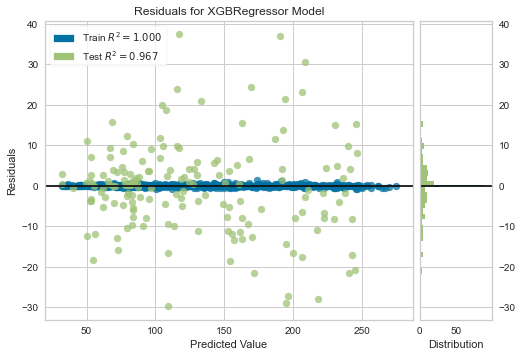

In [26]:
visualizer5 = ResidualsPlot(pipeline_xgb)

visualizer5.fit(X_train.values, y_train)  
visualizer5.score(X_test.values, y_test)  
visualizer5.show();                

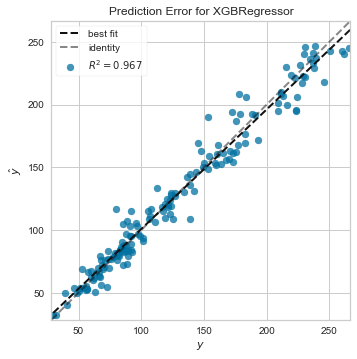

In [27]:
visualizer6 = PredictionError(pipeline_xgb)
visualizer6.fit(X_train.values, y_train)
visualizer6.score(X_test.values, y_test) 
visualizer6.show();                 

***Light GBM***

In [28]:
pipeline_lgb = pipelines['LGB'].fit(X_train.values, y_train)
#pipelines['LGB'].fit(X_train.values, y_train)
# Make prediction on the test set
y_pred_lgb = pipeline_lgb.predict(X_test.values)

In [29]:
mse_lgb = mean_squared_error(y_test, y_pred_lgb, squared = False)
mae_lgb = mean_absolute_error(y_test, y_pred_lgb)

print('LightGBM model performance - test set')
print('r2_score: ', r2_score(y_test, y_pred_lgb))
print('Root Mean Squared Error: %.2f' % np.sqrt(mse_lgb))
print('Root Mean Absolute Error: %.2f' % np.sqrt(mae_lgb))

LightGBM model performance - test set
r2_score:  0.971872536020996
Root Mean Squared Error: 3.20
Root Mean Absolute Error: 2.78


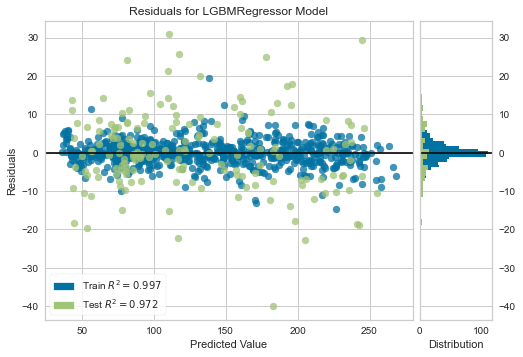

In [30]:
visualizer7 = ResidualsPlot(pipeline_lgb)

visualizer7.fit(X_train.values, y_train)  
visualizer7.score(X_test.values, y_test)  
visualizer7.show();               

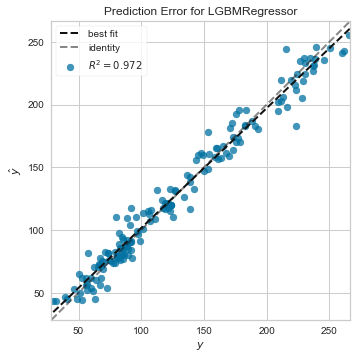

In [31]:
visualizer8 = PredictionError(pipeline_lgb)
visualizer8.fit(X_train.values, y_train)  
visualizer8.score(X_test.values, y_test)  
visualizer8.show();                 

We reach an equally good performance with XGBoost, LightGBM, RandomForestRegressor. Out of the 3 models, LightGBM is the one performing better.

### c) Validating model on validation set

Now we will make predictions using the validation set in order to validate our model. We will only use the following models in the validation part:
- Linear Regression model for explainability (despite its poorer model performance)
- LightGBM model as it is the best performing model

In [32]:
# Import validation data, and split target andfeature variables
val_df = pd.read_csv('solarcast_train.csv')
X_val = val_df.drop(['Daily_radiation'], axis=1)
y_val = val_df['Daily_radiation']

In [33]:
y_val_lr = pipeline_lr.predict(X_val.values)
y_val_lgb = pipeline_lgb.predict(X_val.values)

In [34]:
# Evaluating algorithm performance for linear regression
mse_lr_val = mean_squared_error(y_val, y_val_lr, squared = False)

mae_lr_val = mean_absolute_error(y_val, y_val_lr)

print('Linear Regression model performance - validation set')
print('r2_score: ', r2_score(y_val, y_val_lr))
print('Root Mean Squared Error: %.2f' % np.sqrt(mse_lr_val))
print('Root Mean Absolute Error: %.2f' % np.sqrt(mae_lr_val))

Linear Regression model performance - validation set
r2_score:  0.8226585093551617
Root Mean Squared Error: 5.01
Root Mean Absolute Error: 4.50


In [35]:
# Evaluating algorithm performance for LightGBM model
mse_lgb_val = mean_squared_error(y_val, y_val_lgb, squared = False)

mae_lgb_val = mean_absolute_error(y_val, y_val_lgb)

print('LightGBM  model performance - validation set')
print('r2_score: ', r2_score(y_val, y_val_lgb))
print('Root Mean Squared Error: %.2f' % np.sqrt(mse_lgb_val))
print('Root Mean Absolute Error: %.2f' % np.sqrt(mae_lgb_val))

LightGBM  model performance - validation set
r2_score:  0.9973404972993501
Root Mean Squared Error: 1.75
Root Mean Absolute Error: 1.46


Model performance improves on the validation set for both the Linear Regression model and the Light GBM model. For the LightGBM model, we almost reach perfect predictions with a R2 = 0.9973
The performance on the validation allow us to validate our LightGBM model.

Model performmance of our LightGBM could be improved by:
- performing hyperparameter tuning
- performing feature selection
- withdrawinb data points with higher prediction residuals

### d) Feature importance/ Model coefficients

Now, we will try to understand which features impact mostly daily radiation in both our models.

***Linear Regression***

In [36]:
coef_table = pd.DataFrame(pipelines['LR']['linearregression'].coef_, index=X_train.columns)
coef_table.rename(columns={0: 'Coefficient'}, inplace=True)
coef_table.sort_values(by='Coefficient', ascending=False)

,Coefficient
Daily_GHI,85.165985
Daily_WindDir,6.684860
Daily_Precip,4.582481
Daily_Pressure,2.978980
month,2.566448
day,0.472292
Daily_WindSpeed,-1.310813
Daily_Humidity,-9.313008
Daily_Temp,-12.841094
Daily_DNI,-79.902511


Top contributing features are Daily GHI, Daily GNI and temperatures. It makes sense that Daily DNI and Daily GHI are the variables contributing most to model performance as they are used in the formula to calculate solar radiations level.

In [ ]:
feature_imp = pd.DataFrame(sorted(zip(pipelines['LGB']['lgbmregressor'].feature_importances_, 
                                      X_train.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features importance',fontname="DejaVu Sans", size=16,fontweight="bold")

plt.show();
#plt.savefig('lgb_importances.png')

Here the most impactful features are also **Daily_GNI** and **Daily DHI**. However as variable #3, there is **Daily precipitation**.

In [ ]:
## Export model and hook it with api

## IV- Experiment tracking 

### a) Experiment tracking with neptune

In [38]:
# import neptune libraries and sklearn integration
import neptune.new as neptune
import neptune.new.integrations.sklearn as npt_utils

In [39]:
api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIxOWRjYjFlOS04NjM1LTQwNmItYThkNi04YzBmYjliNWQ2YzMifQ=="
workspace = "sandra.boniface23"# MOI
project_name = 'Solacast'
project = workspace + "/" + project_name

In [40]:
run = neptune.init(api_token = api_token, project= project)

https://app.neptune.ai/sandra.boniface23/Solacast/e/SOL-4


Info (NVML): NVML Shared Library Not Found. GPU usage metrics may not be reported. For more information, see https://docs-legacy.neptune.ai/logging-and-managing-experiment-results/logging-experiment-data.html#hardware-consumption 


Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


In [41]:
# Track files, models, and folders
# File
run["cleaned_datasets"].track_files("solarcast_df_clean281221.csv")
run["raw_datasets"].track_files("48.843519_2246138_Solcast_PT60M.csv")

# Folder
run["notebooks"].track_files("Solcast_model_development.ipynb")

Did not log feature importance chart. Error: could not find feature importances param on Pipeline
Did not log feature importance chart. Error: could not find feature importances param on Pipeline
Did not log feature importance chart. Error: could not find feature importances param on Pipeline


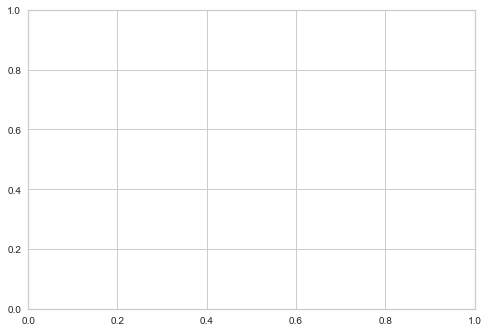

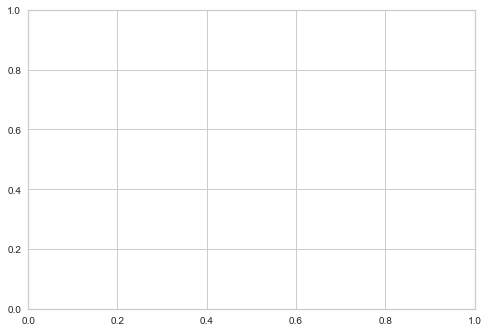

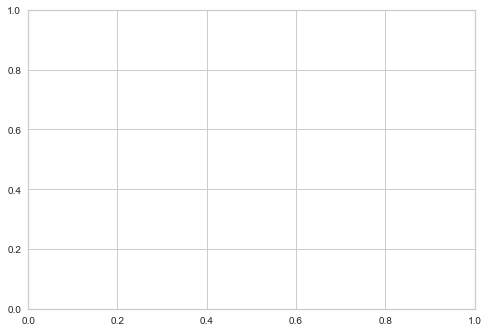

In [42]:
# train, and test; while tracking the experiment
run['lr_summary'] = npt_utils.create_regressor_summary(pipeline_lr, X_train.values, X_test.values, y_train, y_test)

run['rfc_summary'] = npt_utils.create_regressor_summary(pipeline_rfc, X_train.values, X_test.values, y_train, y_test)

run['lgb_summary'] = npt_utils.create_regressor_summary(pipeline_lgb, X_train.values, X_test.values, y_train, y_test)


In [43]:
# stop experiment
run.stop()

Shutting down background jobs, please wait a moment...
Done!


Waiting for the remaining 84 operations to synchronize with Neptune. Do not kill this process.


All 84 operations synced, thanks for waiting!


### b) Experiment tracking with mlflow

Command to run in Terminal before running any Jupyter Notebook cell for mlflow:

mlflow server \--backend-store-uri sqlite:///mlflow.db \--default-artifact-root ./artifacts \--host 0.0.0.0

Make sure to run this command inside folder where the current notebook is located usind **cd**

After this command the local server http://127.0.0.1:5000/#/ should be activated

In [44]:
# import libraries
import mlflow
import mlflow.sklearn

In [45]:
# model metrics for linear regression
rmse_lr_pred = np.sqrt(mean_squared_error(y_test, y_pred_lr, squared = False))
rmae_lr_pred = np.sqrt(mean_absolute_error(y_test, y_pred_lr))
R2_score_lr = r2_score(y_test, y_pred_lr)

# model metrics for random forest
rmse_rfc_pred = np.sqrt(mean_squared_error(y_test, y_pred_rfc, squared = False))
rmae_rfc_pred = np.sqrt(mean_absolute_error(y_test, y_pred_rfc))
R2_score_rfc = r2_score(y_test, y_pred_rfc)

# model metrics for gradient boost
rmse_lgb_pred = np.sqrt(mean_squared_error(y_test, y_pred_lgb, squared = False))
rmae_lgb_pred = np.sqrt(mean_absolute_error(y_test, y_pred_lgb))
R2_score_lgb = r2_score(y_test, y_pred_lgb)

***manually log experiment***

In [46]:
 #set the tracking uri
mlflow.set_tracking_uri("http://127.0.0.1:5000/")
experiment = mlflow.get_experiment('0')

In [47]:
print("Name of experiment: {}".format(experiment.name))
print("Location of Artifact: {}".format(experiment.artifact_location))
print("Life cycle phase: {}".format(experiment.lifecycle_stage))
print("Experiment_ID: {}".format(experiment.experiment_id))

Name of experiment: Default
Location of Artifact: ./artifacts/0
Life cycle phase: active
Experiment_ID: 0


In [48]:
# start experiment tracking
run = mlflow.start_run(run_name = 'solar_irradiation')
run_id = run.info.run_id

In [49]:
# Log mlflow attributes for mlflow UI
# log metrics for linear regression
mlflow.log_metric("rmse_lr", rmse_lr_pred)
mlflow.log_metric("rmae_lr", rmae_lr_pred)
mlflow.log_metric("r2_score_lr", R2_score_lr)

# log metrics for random forest
mlflow.log_metric("rmse_rfc", rmse_rfc_pred)
mlflow.log_metric("rmae_rfc", rmae_rfc_pred)
mlflow.log_metric("r2_score_rfc", R2_score_rfc)

# log metrics for gradientboost
mlflow.log_metric("rmse_lgb", rmse_lgb_pred)
mlflow.log_metric("rmae_lgb", rmae_lgb_pred)
mlflow.log_metric("r2_score_lgb", R2_score_lgb)

In [50]:
# log models experiments
artifact_path = "default"
mlflow.sklearn.log_model(pipeline_lr, artifact_path = artifact_path, registered_model_name = "linear-regression-model")
mlflow.sklearn.log_model(pipeline_rfc, artifact_path = artifact_path, registered_model_name = "sklearn-random-forest-model")
mlflow.sklearn.log_model(pipeline_lgb, artifact_path = artifact_path, registered_model_name = "sklearn-lightgbm-model")

Successfully registered model 'linear-regression-model'.
2022/01/04 17:53:48 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: linear-regression-model, version 1
Created version '1' of model 'linear-regression-model'.
Successfully registered model 'sklearn-random-forest-model'.
2022/01/04 17:53:57 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: sklearn-random-forest-model, version 1
Created version '1' of model 'sklearn-random-forest-model'.
Successfully registered model 'sklearn-lightgbm-model'.
2022/01/04 17:54:04 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: sklearn-lightgbm-model, version 1
Created version '1' of model 'sklearn-lightgbm-model'.


In [51]:
# Log artifacts (output files)
#mlflow.log_artifact("lr_line_of_fit.jpg", artifact_path = 'features')

# Log Features
mlflow.log_artifact('solarcast_train.csv', artifact_path = 'features')

In [52]:
# End tracking
mlflow.end_run()

***Auto log experiment***

In [53]:
# enable auto logging
mlflow.sklearn.autolog(log_models = True)

2022/01/04 18:04:36 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.


In [54]:
with mlflow.start_run(experiment_id = experiment.experiment_id, run_name = 'auto_lr_model') as run:
    pipeline_lr.fit(X_train.values,y_train)
    y_pred_lr = pipeline_lr.predict(X_test.values)
    pipeline_rfc.fit(X_train.values,y_train)
    y_pred_rfc = pipeline_rfc.predict(X_test.values)
    pipeline_lgb.fit(X_train.values, y_train)
    y_pred_lgb = pipeline_lgb.predict(X_test.values)

2022/01/04 18:05:05 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 2f713985f3e8481bb910990995935ae6. Failed operations: [RestException("INVALID_PARAMETER_VALUE: Changing param values is not allowed. Param with key=\'steps\' was already logged with value=\'[(\'standardscaler\', StandardScaler()), (\'linearregression\', LinearRegression())]\' for run ID=\'2f713985f3e8481bb910990995935ae6\'. Attempted logging new value \'[(\'standardscaler\', StandardScaler()), (\'randomforestregressor\', RandomForestRegressor(random_state=1))]\'.")]')]
2022/01/04 18:05:16 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more opera

In [55]:
# End tracking
mlflow.end_run()

***Export models***

In [56]:
# check sklearn version
from sklearn import __version__

print(__version__)

1.0.2


In [59]:
import joblib
# Save Models to file in the model directory
# save linear regression model
joblib_lr = "model_lr.pkl"  
joblib.dump(pipeline_lr, joblib_lr)

['model_lr.pkl']

In [60]:
# save random forest model
joblib_rfc = "model_rfc.pkl" 
joblib.dump(pipeline_rfc, joblib_rfc)

['model_rfc.pkl']

In [61]:
# save gradientboost model
joblib_lgb = "model_lgb.pkl"  
joblib.dump(pipeline_lgb, joblib_lgb)

['model_lgb.pkl']

Recommended reading
https://docs.neptune.ai/integrations-and-supported-tools/model-training/sklearn

https://mlflow.org/docs/latest/tracking.html#scenario-1-mlflow-on-localhost

https://docs.neptune.ai/getting-started/examples#data-versioning

In [65]:
print("'Temperatures")
print(f"Temperature min {np.round(df['Daily_Temp'].min(),0)}")
print(f"Temperature max {np.round(df['Daily_Temp'].max(),0)}")
print(f"Temperature mean {np.round(df['Daily_Temp'].mean(),0)}")

'Temperatures
Temperature min -2.0
Temperature max 36.0
Temperature mean 14.0


In [66]:
print("Precipitations")
print(f"Precipitations min {np.round(df['Daily_Precip'].min(),0)}")
print(f"Temperature max {np.round(df['Daily_Precip'].max(),0)}")
print(f"Temperature mean {np.round(df['Daily_Precip'].mean(),0)}")

Precipitations
Precipitations min 3.0
Temperature max 44.0
Temperature mean 17.0


In [67]:
print("Humidity")
print(f"Humidity min {np.round(df['Daily_Humidity'].min(),0)}")
print(f"Humidity max {np.round(df['Daily_Humidity'].max(),0)}")
print(f"Humidity mean {np.round(df['Daily_Humidity'].mean(),0)}")

Humidity
Humidity min 24.0
Humidity max 95.0
Humidity mean 63.0


In [68]:
print("Pressure")
print(f"Pressure min {np.round(df['Daily_Pressure'].min(),0)}")
print(f"Pressure max {np.round(df['Daily_Pressure'].max(),0)}")
print(f"Pressure mean {np.round(df['Daily_Pressure'].mean(),0)}")

Pressure
Pressure min 964.0
Pressure max 1034.0
Pressure mean 1005.0


In [69]:
print('wind direction')
print(f"wind direction {np.round(df['Daily_WindDir'].min(),0)}")
print(f"wind direction {np.round(df['Daily_WindDir'].max(),0)}")
print(f"wind direction {np.round(df['Daily_WindDir'].mean(),0)}")

wind direction
wind direction 7.0
wind direction 351.0
wind direction 188.0


In [70]:
print('wind Speed')
print(f"wind Speed {np.round(df['Daily_WindSpeed'].min(),0)}")
print(f"wind Speed {np.round(df['Daily_WindSpeed'].max(),0)}")
print(f"wind Speed {np.round(df['Daily_WindSpeed'].mean(),0)}")

wind Speed
wind Speed 1.0
wind Speed 11.0
wind Speed 4.0


In [74]:
print('DNI')
print(f"DNI min {np.round(df['Daily_DNI'].min(),0)}")
print(f"DNI max {np.round(df['Daily_DNI'].max(),0)}")
print(f"DNI mean {np.round(df['Daily_DNI'].mean(),0)}")

DNI
DNI min 0.0
DNI max 750.0
DNI mean 235.0


In [75]:
print('GHI')
print(f"GHI min {np.round(df['Daily_GHI'].min(),0)}")
print(f"GHI max {np.round(df['Daily_GHI'].max(),0)}")
print(f"GHI mean {np.round(df['Daily_GHI'].mean(),0)}")

GHI
GHI min 29.0
GHI max 525.0
GHI mean 248.0


In [76]:
np.round(df['Daily_Temp'].min(),0)-2

-4.0

In [ ]:
temperature = st.sidebar.slider(label = 'Average daily temperature', min_value = np.round(df['Daily_Temp'].min(),0)-2,
                          max_value = np.round(df['Daily_Temp'].max(),0)+2,
                          value = np.round(df['Daily_Temp'].mean(),0),
                          step = 1)

precipitations = st.sidebar.slider(label = 'Average daily precipitations', min_value = np.round(df['Daily_Precip'].min(),0),
                          max_value = np.round(df['Daily_Precip'].max(),0),
                          value = np.round(df['Daily_Precip'].mean(),0),
                          step = 1)

humidty= st.sidebar.slider(label = 'Average daily humidty', min_value = np.round(df['Daily_Humidity'].min(),0),
                          max_value = np.round(df['Daily_Humidity'].max(),0),
                          value = np.round(df['Daily_Humidity'].mean(),0),
                          step = 1)

pressure = st.sidebar.slider(label = 'Average daily pressure', min_value = np.round(df['Daily_Pressure'].min(),0),
                          max_value = np.round(df['Daily_Pressure'].max(),0),
                          value = np.round(df['Daily_Pressure'].mean(),0),
                          step = 1)


wind_direction = st.sidebar.slider(label = 'Average daily wind direction', min_value = np.round(df['Daily_WindDir'].min(),0),
                          max_value = np.round(df['Daily_WindDir'].max(),0),
                          value = np.round(df['Daily_WindDir'].mean(),0),
                          step = 1)

wind_speed = st.sidebar.slider(label = 'Average daily  wind speed', min_value = np.round(df['Daily_WindSpeed'].min(),0),
                          max_value = np.round(df['Daily_WindSpeed'].max(),0),
                          value = np.round(df['Daily_WindSpeed'].mean(),0),
                          step = 1)

dni = st.sidebar.slider(label = 'Average daily DNI', min_value = np.round(df['Daily_DNI'].min(),0),
                          max_value = np.round(df['Daily_DNI'].max(),0),
                          value = np.round(df['Daily_DNI'].mean(),0),
                          step = 1)

ghi = st.sidebar.slider(label = 'Average daily GHI',  min_value = np.round(df['Daily_GHI'].min(),0),
                          max_value = np.round(df['Daily_GHI'].max(),0),
                          value = np.round(df['Daily_GHI'].mean(),0),
                          step = 1)

In [77]:
df.columns

Index(['month', 'day', 'Daily_Temp', 'Daily_Precip', 'Daily_Humidity',
       'Daily_Pressure', 'Daily_WindDir', 'Daily_WindSpeed', 'Daily_DNI',
       'Daily_GHI', 'Daily_radiation'],
      dtype='object')

In [81]:
df['day'].unique().sort_values()

AttributeError: 'numpy.ndarray' object has no attribute 'sort_values'

In [83]:
df['month'].unique()

array([12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [86]:
month_number = [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]

In [87]:
month_list = ['January','February','March','April', 'May', 'June', 'July', 'August','September', 'October', 'November', 'December']

In [97]:
from platform import python_version

print(python_version())

3.8.8


In [90]:
#sorted(list(df['day'].unique()))

In [92]:
df2 = df.copy()

In [95]:
df2['month'] = df2['month'].map(dict(zip(month_number, month_list)))

In [96]:
df2['month']

0       December
1        January
2        January
3        January
4        January
          ...   
1082    December
1083    December
1084    December
1085    December
1086    December
Name: month, Length: 1087, dtype: object

In [ ]:
features_df['month'] = features_df['month'].map(dict(zip(month_list, month_number)))

In [105]:
list_day = sorted([df['day'].unique()])

In [106]:
list_day

[array([31,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])]

In [107]:
list_day = [1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31]

In [108]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1087 entries, 0 to 1086
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   month            1087 non-null   int64  
 1   day              1087 non-null   int64  
 2   Daily_Temp       1087 non-null   float64
 3   Daily_Precip     1087 non-null   float64
 4   Daily_Humidity   1087 non-null   float64
 5   Daily_Pressure   1087 non-null   float64
 6   Daily_WindDir    1087 non-null   float64
 7   Daily_WindSpeed  1087 non-null   float64
 8   Daily_DNI        1087 non-null   float64
 9   Daily_GHI        1087 non-null   float64
 10  Daily_radiation  1087 non-null   float64
dtypes: float64(9), int64(2)
memory usage: 93.5 KB


In [ ]:
df['Daily_Temp'] = df['Daily_Temp'].astype(float)
df['Daily_Precip'] = df['Daily_Precip'].astype(float)
df['Daily_Humidity'] = df['Daily_Humidity'].astype(float)
df['Daily_Pressure'] = df['Daily_Pressure'].astype(float)
df['Daily_WindDir'] = df['Daily_WindDir'].astype(float)
df['Daily_WindSpeed'] = df['Daily_WindSpeed'].astype(float)
df['Daily_DNI'] = df['Daily_DNI'].astype(float)
df['Daily_GHI'] = df['Daily_GHI'].astype(float)